In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from IPython.display import Image
import scrublet as scr

sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/jupyter_server/transutils.py:13: FutureWarning: The alias `_()` will be deprecated. Use `_i18n()` instead.
  warnings.warn(warn_msg, FutureWarning)


-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
appnope             0.1.2
argon2              20.1.0
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairocffi           1.2.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                3.1.0
idna                2.10
igraph              0.9.1
ipykernel           5.5.0
ipython_genutils    0.2.0
jedi                0.17.2
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.5.0
jupyterlab_server   2.3.0
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.3
llvmlite            0.36.0
markupsafe          1.1.1
m

In [2]:

results_file = '../data/pbmc68k.h5ad'  # the file that will store the analysis results
results_T_file = '../data/pbmc68k_Tcells.h5ad'  # the file that will store the analysis results

In [3]:
adata = sc.read_10x_mtx(
    '../data/matrices_mex/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',      # use gene symbols for the variable names (variables-axis index)
    cache=True)

In [4]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [5]:
adata

AnnData object with n_obs × n_vars = 5898240 × 32738
    var: 'gene_ids'

In [6]:
## Filter pseudogenes and other strange genes without a lot of biological interpretability
adata = adata[:,[x for x in adata.var.index if '.' not in x]]

In [13]:
sc.pp.filter_cells(adata, min_counts=10)


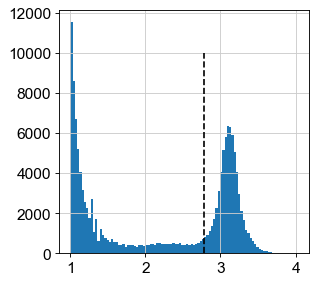

In [20]:
_ = plt.hist(adata.obs['n_counts'].apply(np.log10), bins=100)
_ = plt.vlines(x=np.log10(600), ymin=0, ymax=10000, color='k', linestyle='--')

In [21]:
## Filter cells with low counts / # genes detected, and genes detected in <10 cells
#sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_cells(adata, min_counts=600)
sc.pp.filter_genes(adata, min_cells=10)

In [22]:
adata

AnnData object with n_obs × n_vars = 65788 × 13381
    obs: 'n_counts'
    var: 'gene_ids', 'n_cells'

## Run scrublet to filter doublets

In [23]:
scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.1)

In [24]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 35.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.7%
Elapsed time: 326.4 seconds


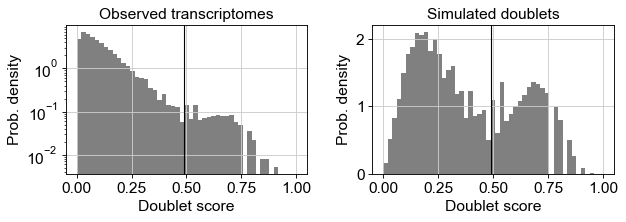

In [25]:
_ = scrub.plot_histogram()

In [26]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))


(<Figure size 640x320 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <AxesSubplot:title={'center':'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

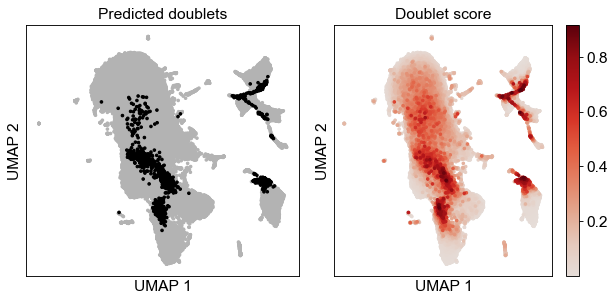

In [27]:
scrub.plot_embedding('UMAP', order_points=True)

In [29]:
adata.obs['doublet_scores'] = doublet_scores
adata.obs['predicted_doublets'] = predicted_doublets

In [30]:
adata.obs['predicted_doublets'].value_counts()

False    64248
True      1540
Name: predicted_doublets, dtype: int64

In [32]:
adata = adata[~adata.obs['predicted_doublets'], :]

In [33]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Trying to set attribute `.obs` of view, copying.


In [36]:
sc.pp.filter_cells(adata, min_genes=0)


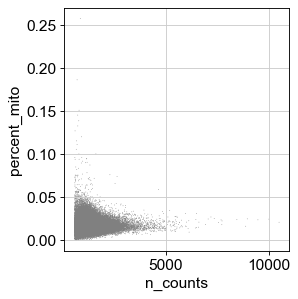

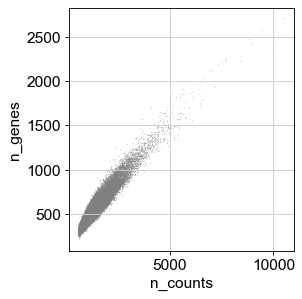

In [37]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [38]:
adata

AnnData object with n_obs × n_vars = 64248 × 13381
    obs: 'n_counts', 'doublet_scores', 'predicted_doublets', 'percent_mito', 'n_genes'
    var: 'gene_ids', 'n_cells'

In [39]:
adata.raw = adata

In [40]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

In [41]:
sc.pp.log1p(adata)

In [42]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=10, min_disp=0.5)


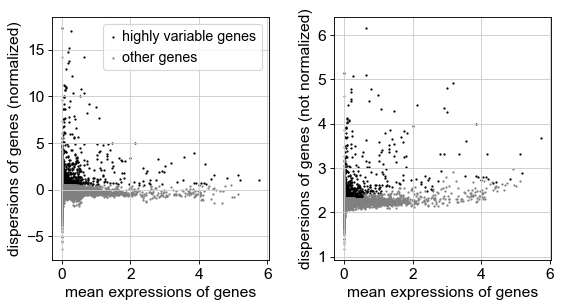

In [43]:
sc.pl.highly_variable_genes(adata)

In [44]:
adata.var['highly_variable'].value_counts()

False    12181
True      1200
Name: highly_variable, dtype: int64

In [45]:
adata.var.sort_values(by='dispersions_norm', ascending=False).head(10)

gene_ids  n_cells  highly_variable     means  dispersions  \
PRSS1  ENSG00000204983       25             True  0.013041     5.149098   
PF4    ENSG00000163737      243             True  0.261422     5.080025   
GNG11  ENSG00000127920      388             True  0.216442     4.778766   
SDPR   ENSG00000168497      304             True  0.193681     4.708147   
PPBP   ENSG00000163736      534             True  0.648532     6.167743   
PRSS3  ENSG00000010438       22            False  0.007826     4.629215   
IGJ    ENSG00000132465      794             True  0.211814     4.553013   
CLU    ENSG00000120885      543             True  0.194366     4.512701   
ACRBP  ENSG00000111644      243             True  0.113250     4.411070   
NCOA4  ENSG00000138293     2318             True  0.308936     3.500431   

       dispersions_norm  
PRSS1         17.345118  
PF4           16.933475  
GNG11         15.138105  
SDPR          14.717244  
PPBP          14.248146  
PRSS3         14.246845  
IGJ           13.792719  
CLU           13.552477  
ACRBP         12.946801  
NCOA4         12.198282

In [46]:
sc.tl.pca(adata, svd_solver='arpack', random_state=14, use_highly_variable=True, zero_center=True)

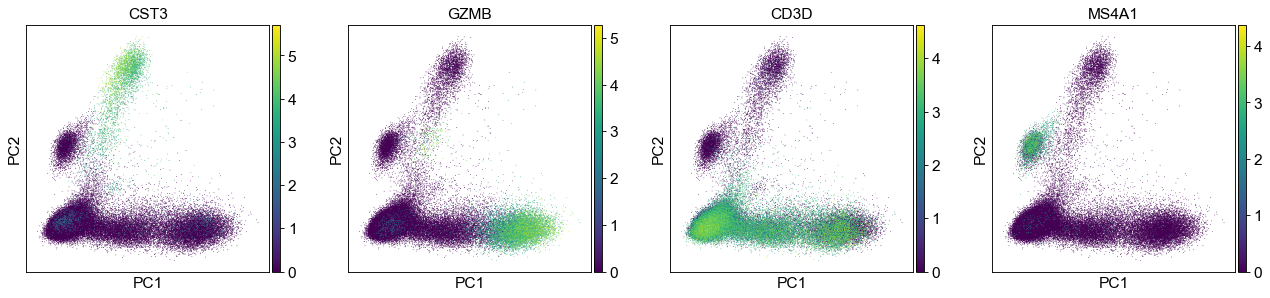

In [47]:
sc.pl.pca(adata, color=['CST3', 'GZMB', 'CD3D', 'MS4A1'], use_raw=False)

/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


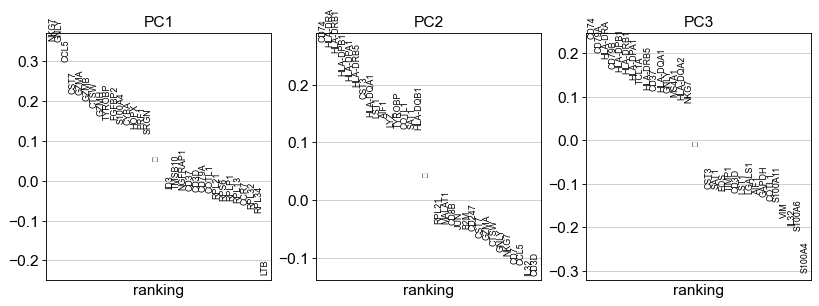

In [48]:
sc.pl.pca_loadings(adata)

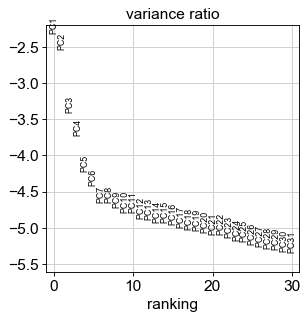

In [49]:
sc.pl.pca_variance_ratio(adata, log=True)

In [50]:
adata

AnnData object with n_obs × n_vars = 64248 × 13381
    obs: 'n_counts', 'doublet_scores', 'predicted_doublets', 'percent_mito', 'n_genes'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [51]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=21, random_state=14)

In [52]:
sc.tl.umap(adata, min_dist=.5, spread=1.0, random_state=14)

In [53]:
adata.obs['log10_ncounts'] = adata.obs['n_counts'].apply(np.log10)

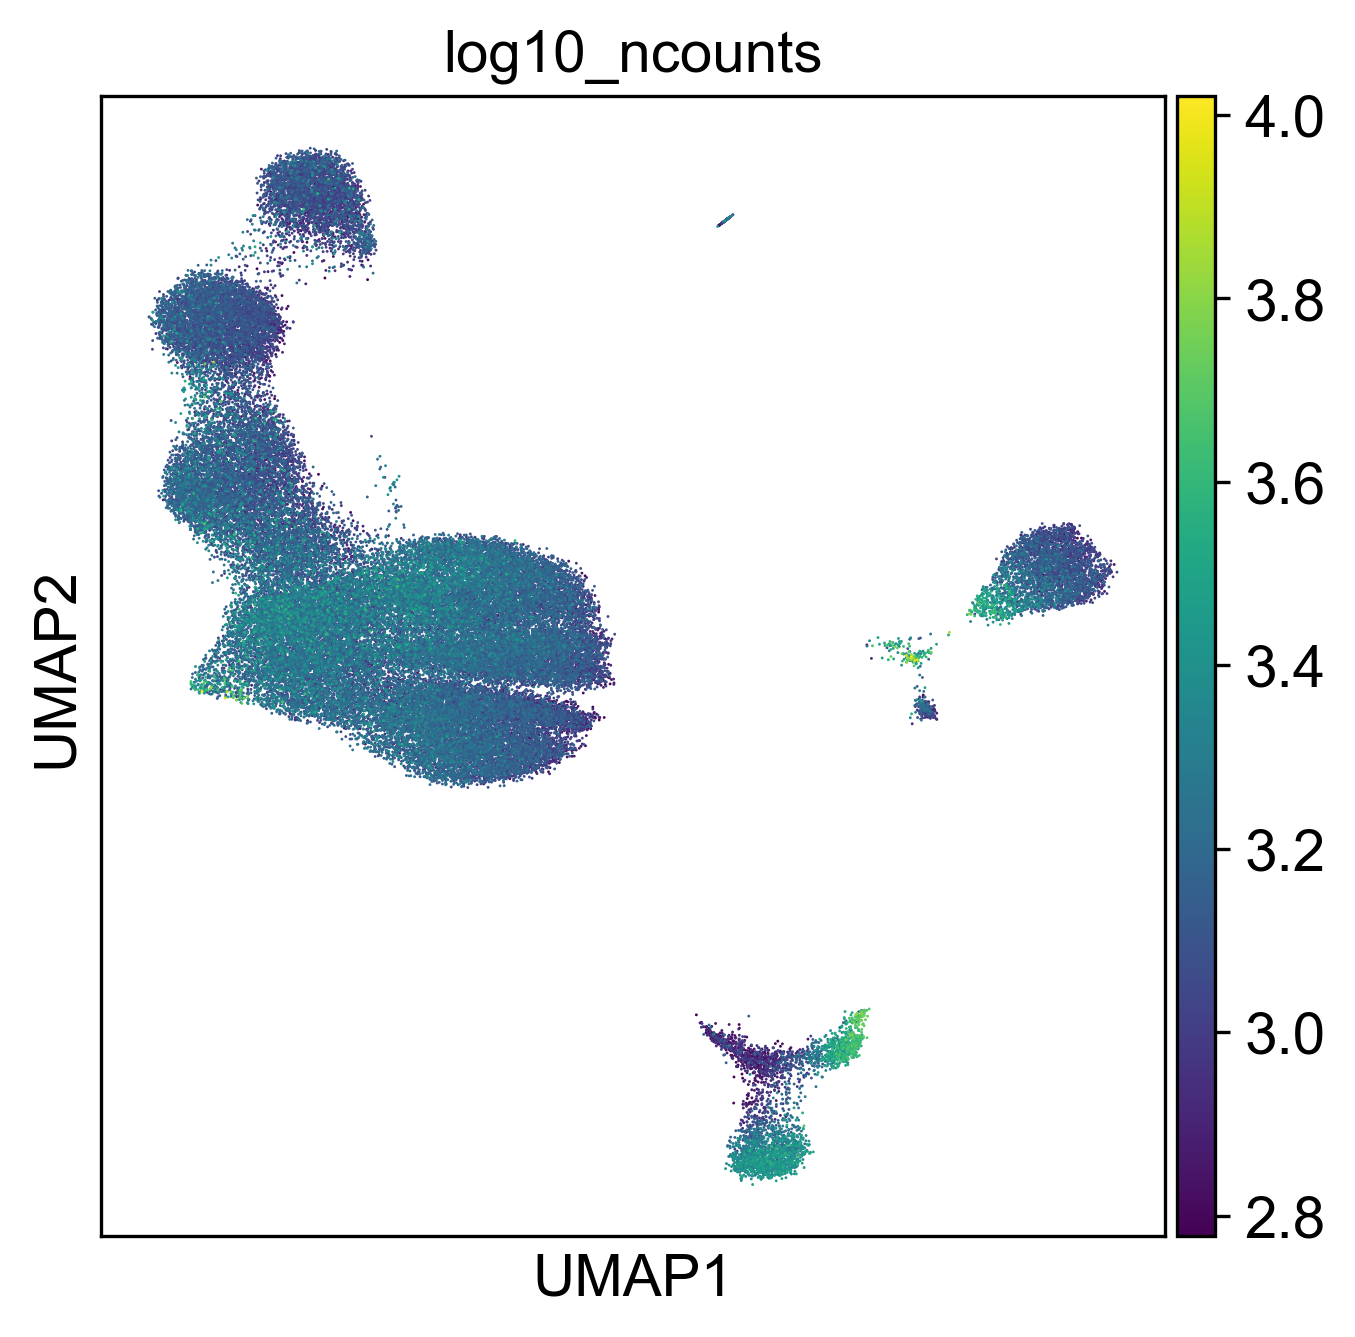

In [54]:
(fig,ax) = plt.subplots(1,1, figsize=(5,5), dpi=300)
sc.pl.umap(adata, color=['log10_ncounts'], ax=ax, )

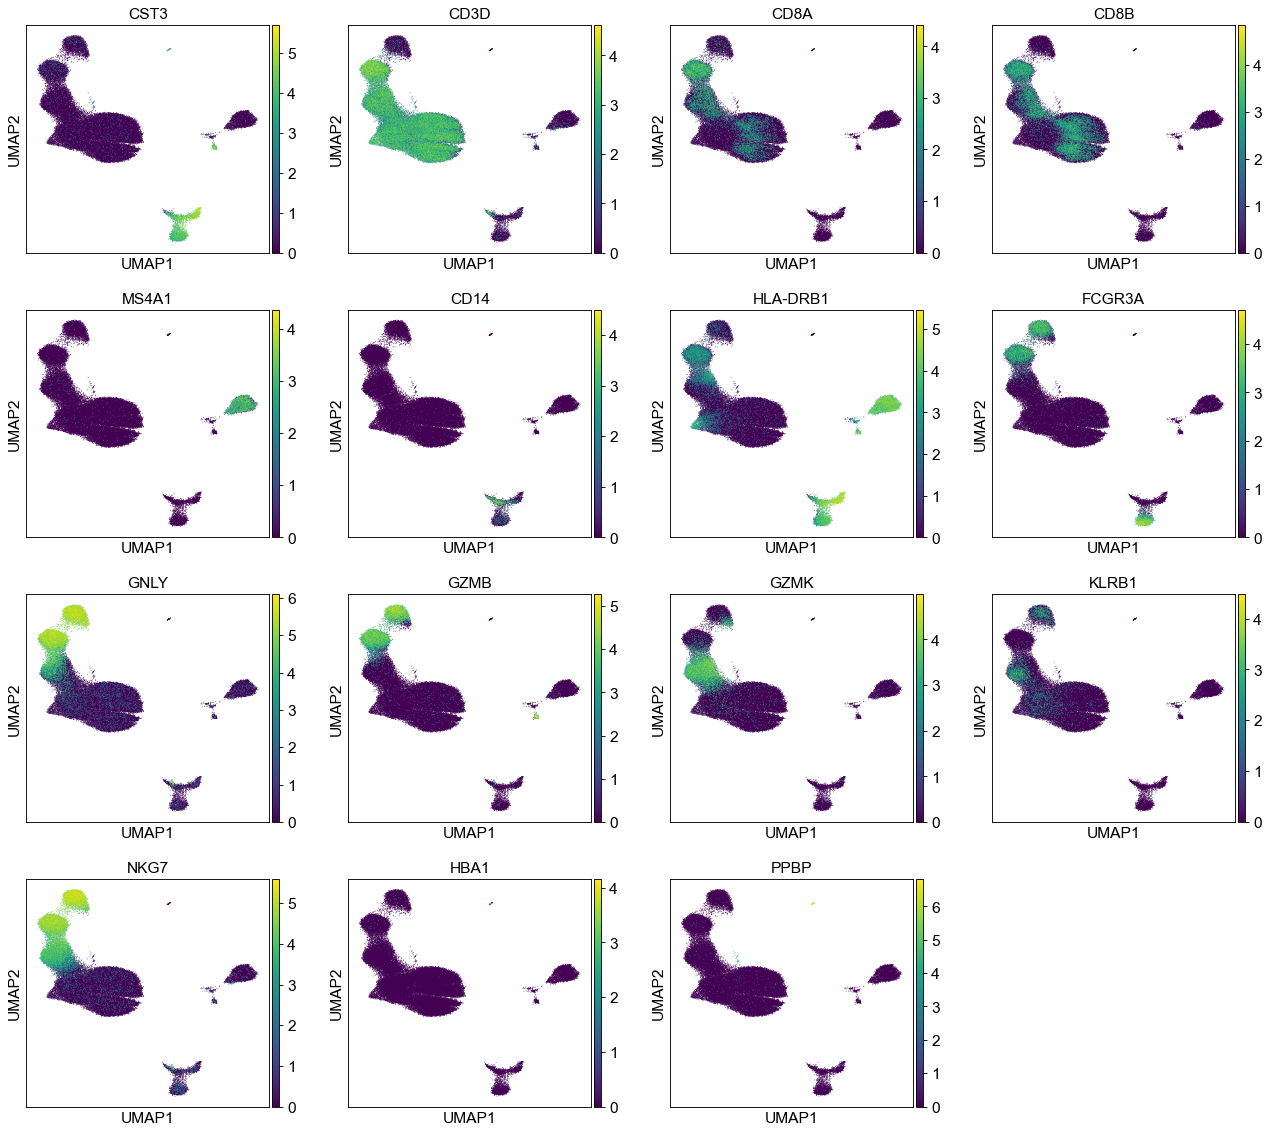

In [56]:
sc.pl.umap(adata, color=['CST3', 'CD3D', 'CD8A', 'CD8B', 'MS4A1', 'CD14', 'HLA-DRB1',
                         'FCGR3A', 'GNLY', 'GZMB', 'GZMK',
                           'KLRB1', 'NKG7', 'HBA1', 'PPBP'
                        ], use_raw=False)

In [57]:
sc.tl.leiden(adata, resolution=1., random_state=14)

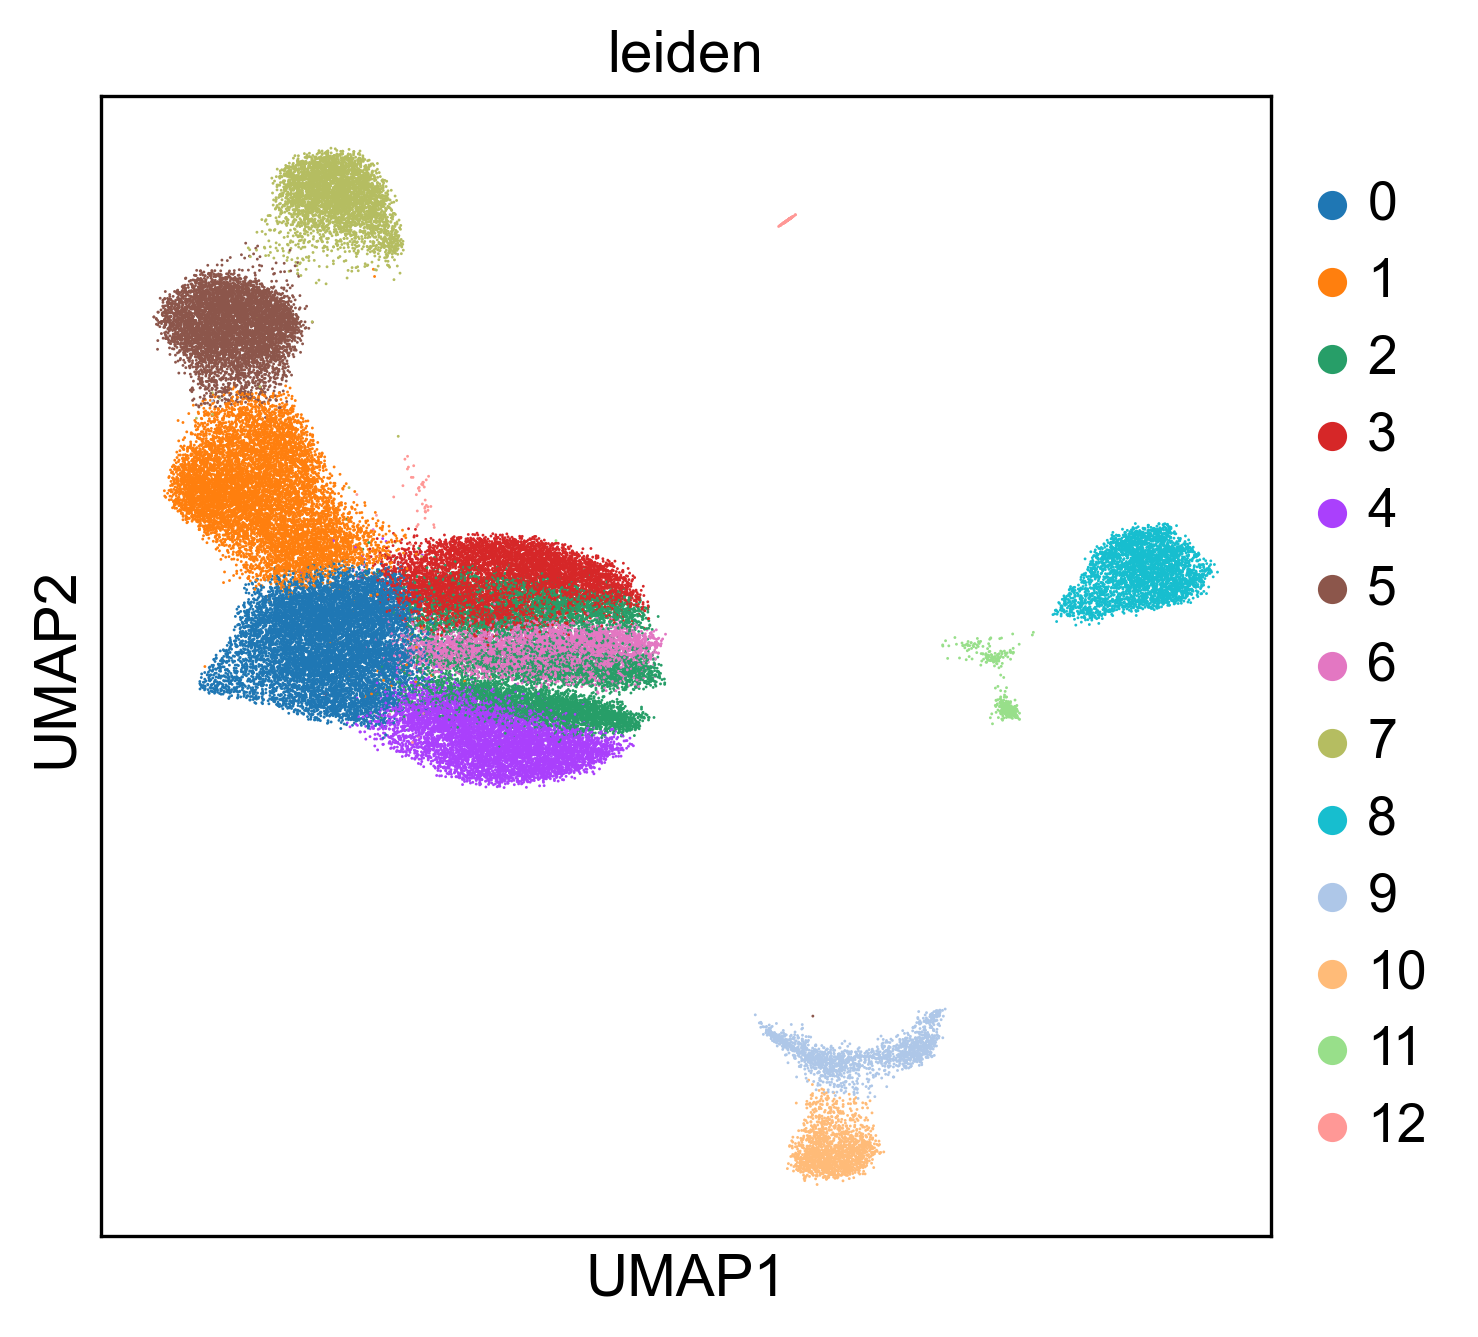

In [58]:
(fig,ax) = plt.subplots(1,1, figsize=(5,5), dpi=300)
sc.pl.umap(adata, color=['leiden'], ax=ax, )

In [59]:
sc.tl.rank_genes_groups(adata, use_raw=False, groupby='leiden')

In [60]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

0       1       2       3       4         5       6       7  \
0       IL32    CCL5   RPL13     JUN  MT-ND2      NKG7    IER2    NKG7   
1     S100A4    GZMK   RPL32    IER2   RPL32      CCL5  MT-ND2    GNLY   
2        LTB    IL32   RPL11  MT-ND2   RPL13      GNLY   RPL32  TYROBP   
3        VIM    NKG7    RPS6   RPL32   RPS3A      GZMH   RPL13    CST7   
4       CD52    GZMA    RPL3   RPL13    RPS6       B2M   RPS3A    GZMB   
5      FXYD5     B2M  RPL13A    RPS6   RPL21      GZMB    RPS6    GZMA   
6    S100A10   DUSP2   RPS27   RPS3A   RPL11      CST7   RPL11    CTSW   
7       LDHB   HLA-B    RPS2   RPL11   RPL34     HLA-B   RPL34  FCER1G   
8      GAPDH    LYAR  RPL18A   RPL34    RPL7     HLA-C   RPL21   CLIC3   
9      GSTK1    CST7   RPL19    RPL7    RPL3      GZMA    RPL3     CD7   
10       B2M   DUSP1   RPS13   RPS12   RPS27    FGFBP2    RPL7     B2M   
11  SH3BGRL3    CTSW   RPS4X    RPL9   RPS13     HLA-A   RPL31    PRF1   
12    S100A6  S100A4   RPS12    LDHB   RPS14      CTSW   RPS27    PFN1   
13      PLP2   HLA-C   RPS14    RPS2    RPL9    TMSB4X    RPL9   HLA-A   
14      TPT1     JUN   RPL10    RPL3   RPS12    S100A4   RPS14    CYBA   
15      AQP3   HLA-A   RPL31   RPL21   RPS4X      IL32   RPS12  FGFBP2   
16     COTL1    HCST   RPS25   RPS4X   RPL31      CYBA   RPS4X    HOPX   
17      IL7R     FOS    RPS5    JUNB    RPS2  SH3BGRL3   RPS25   HLA-B   
18     ANXA1  MT-CO1   RPLP2   RPS13   RPS25    MALAT1    RPS2   HLA-C   
19     TRADD   KLRG1  RPL10A   RPS25  RPL13A      CD99  RPL13A  IFITM2   

            8         9        10        11         12  
0        CD74      CST3      LST1      CD74       PPBP  
1     HLA-DRA    TYROBP      AIF1      GPX1       GPX1  
2    HLA-DRB1  HLA-DRB1    TYROBP  HLA-DRB1      GNG11  
3       CD79A       LYZ      FTH1   HLA-DRA        PF4  
4    HLA-DPB1    S100A4       FTL      CYBA       SDPR  
5    HLA-DPA1      CD74    FCER1G      MZB1       OAZ1  
6       CD79B      CYBA      CST3     ITM2C        CLU  
7    HLA-DRB5      AIF1      SAT1      CST3     TAGLN2  
8        CD37     GSTP1     COTL1    SEC61B       NRGN  
9    HLA-DQA1      GPX1    S100A4     SERF2      TUBB1  
10   HLA-DQA2      LST1  HLA-DRB1  HLA-DPB1       FTH1  
11        LTB       FTL      CD74  HLA-DRB5      NCOA4  
12   HLA-DQB1    TMSB10      PSAP      IRF7       CCL5  
13      MS4A1      FTH1   S100A11     DERL3      CMTM5  
14      TCL1A    S100A6      OAZ1      FTH1  HIST1H2AC  
15    HLA-DMA    S100A9   HLA-DRA      SSR4   SH3BGRL3  
16     RPL18A    LGALS1      CTSS      MYL6       SAT1  
17    HLA-DMB   HLA-DRA  HLA-DPA1      NPC2      SPARC  
18      HVCN1  HLA-DRB5       CFD    LRRC26     TREML1  
19  LINC00926  HLA-DPB1      MYL6      GZMB     MYL12A

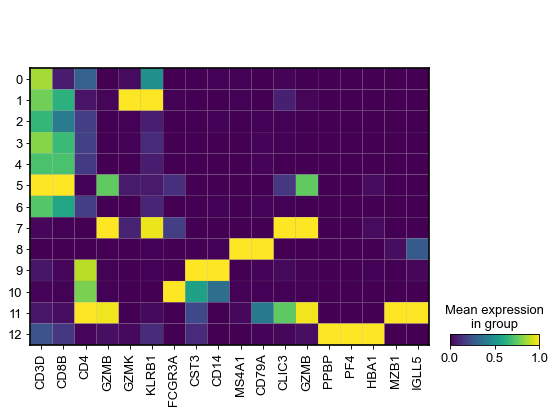

In [64]:
sc.pl.matrixplot(adata, var_names=['CD3D', 'CD8B', 'CD4', 'GZMB', 'GZMK',
                                   'KLRB1', 'FCGR3A',
                                   'CST3', 'CD14',
                                   'MS4A1', 'CD79A',
                                   'CLIC3', 'GZMB',
                                  'PPBP', 'PF4', 'HBA1', 'MZB1', 'IGLL5'],
                 groupby='leiden', standard_scale='var')

In [68]:
clustermap = {'0':'Th 1', '1':'Tc 1', '2':'Th 2', '3':'Th 3',
             '4':'Th 4', '5':'Tc 2', '6':'Th 6', '7':'NK 1',
             '8':'B 1', '9':'Mono_CD14 1', '10':'Mono_CD16 1', 
             '11':'pDC/plasmabast 1', '12':'Platelet/RBC 1'}

In [69]:
adata.obs['ClusterFull_1'] = adata.obs['leiden'].replace(clustermap)
adata.obs['Cluster_1'] = adata.obs['ClusterFull_1'].apply(lambda x: x.split(' ')[0])

... storing 'ClusterFull_1' as categorical
... storing 'Cluster_1' as categorical


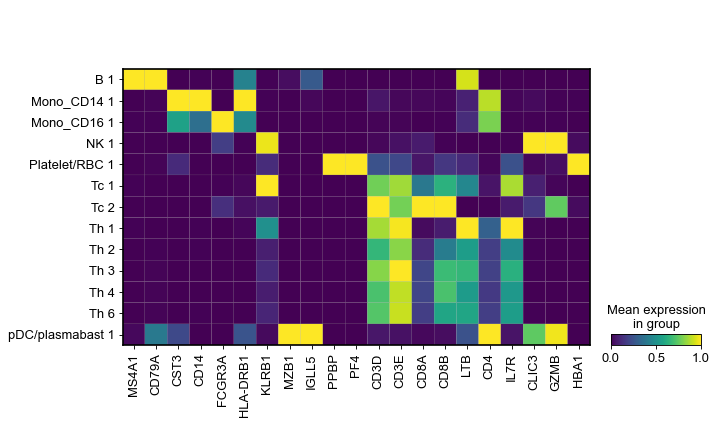

In [70]:
sc.pl.matrixplot(adata, var_names=['MS4A1', 'CD79A',
                                   'CST3', 'CD14', 'FCGR3A', 'HLA-DRB1',
                                   'KLRB1', 
                                    'MZB1', 'IGLL5',
                                   'PPBP', 'PF4',
                                   'CD3D','CD3E', 'CD8A', 'CD8B', 'LTB','CD4', 'IL7R',
                                   
                                   'CLIC3', 'GZMB', 'HBA1',
                                   ],
                 groupby='ClusterFull_1', standard_scale='var')

In [71]:
sc.tl.rank_genes_groups(adata, use_raw=False, groupby='ClusterFull_1')

In [72]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

B 1 Mono_CD14 1 Mono_CD16 1    NK 1 Platelet/RBC 1    Tc 1  \
0        CD74        CST3        LST1    NKG7           PPBP    CCL5   
1     HLA-DRA      TYROBP        AIF1    GNLY           GPX1    GZMK   
2    HLA-DRB1    HLA-DRB1      TYROBP  TYROBP          GNG11    IL32   
3       CD79A         LYZ        FTH1    CST7            PF4    NKG7   
4    HLA-DPB1      S100A4         FTL    GZMB           SDPR    GZMA   
5    HLA-DPA1        CD74      FCER1G    GZMA           OAZ1     B2M   
6       CD79B        CYBA        CST3    CTSW            CLU   DUSP2   
7    HLA-DRB5        AIF1        SAT1  FCER1G         TAGLN2   HLA-B   
8        CD37       GSTP1       COTL1   CLIC3           NRGN    LYAR   
9    HLA-DQA1        GPX1      S100A4     CD7          TUBB1    CST7   
10   HLA-DQA2        LST1    HLA-DRB1     B2M           FTH1   DUSP1   
11        LTB         FTL        CD74    PRF1          NCOA4    CTSW   
12   HLA-DQB1      TMSB10        PSAP    PFN1           CCL5  S100A4   
13      MS4A1        FTH1     S100A11   HLA-A          CMTM5   HLA-C   
14      TCL1A      S100A6        OAZ1    CYBA      HIST1H2AC     JUN   
15    HLA-DMA      S100A9     HLA-DRA  FGFBP2       SH3BGRL3   HLA-A   
16     RPL18A      LGALS1        CTSS    HOPX           SAT1    HCST   
17    HLA-DMB     HLA-DRA    HLA-DPA1   HLA-B          SPARC     FOS   
18      HVCN1    HLA-DRB5         CFD   HLA-C         TREML1  MT-CO1   
19  LINC00926    HLA-DPB1        MYL6  IFITM2         MYL12A   KLRG1   

        Tc 2      Th 1    Th 2    Th 3    Th 4    Th 6 pDC/plasmabast 1  
0       NKG7      IL32   RPL13     JUN  MT-ND2    IER2             CD74  
1       CCL5    S100A4   RPL32    IER2   RPL32  MT-ND2             GPX1  
2       GNLY       LTB   RPL11  MT-ND2   RPL13   RPL32         HLA-DRB1  
3       GZMH       VIM    RPS6   RPL32   RPS3A   RPL13          HLA-DRA  
4        B2M      CD52    RPL3   RPL13    RPS6   RPS3A             CYBA  
5       GZMB     FXYD5  RPL13A    RPS6   RPL21    RPS6             MZB1  
6       CST7   S100A10   RPS27   RPS3A   RPL11   RPL11            ITM2C  
7      HLA-B      LDHB    RPS2   RPL11   RPL34   RPL34             CST3  
8      HLA-C     GAPDH  RPL18A   RPL34    RPL7   RPL21           SEC61B  
9       GZMA     GSTK1   RPL19    RPL7    RPL3    RPL3            SERF2  
10    FGFBP2       B2M   RPS13   RPS12   RPS27    RPL7         HLA-DPB1  
11     HLA-A  SH3BGRL3   RPS4X    RPL9   RPS13   RPL31         HLA-DRB5  
12      CTSW    S100A6   RPS12    LDHB   RPS14   RPS27             IRF7  
13    TMSB4X      PLP2   RPS14    RPS2    RPL9    RPL9            DERL3  
14    S100A4      TPT1   RPL10    RPL3   RPS12   RPS14             FTH1  
15      IL32      AQP3   RPL31   RPL21   RPS4X   RPS12             SSR4  
16      CYBA     COTL1   RPS25   RPS4X   RPL31   RPS4X             MYL6  
17  SH3BGRL3      IL7R    RPS5    JUNB    RPS2   RPS25             NPC2  
18    MALAT1     ANXA1   RPLP2   RPS13   RPS25    RPS2           LRRC26  
19      CD99     TRADD  RPL10A   RPS25  RPL13A  RPL13A             GZMB

In [73]:
adata.write(results_file)

In [74]:
adata = sc.read(results_file)

In [75]:
adata.obs['Cluster_1'].value_counts()

Th                37810
Tc                15089
NK                 4097
B                  3435
Mono_CD14          1644
Mono_CD16          1605
pDC/plasmabast      425
Platelet/RBC        143
Name: Cluster_1, dtype: int64

In [76]:
pd.crosstab(adata.obs['Cluster_1'], adata.obs['ClusterFull_1'])

ClusterFull_1    B 1  Mono_CD14 1  Mono_CD16 1  NK 1  Platelet/RBC 1  Tc 1  \
Cluster_1                                                                    
B               3435            0            0     0               0     0   
Mono_CD14          0         1644            0     0               0     0   
Mono_CD16          0            0         1605     0               0     0   
NK                 0            0            0  4097               0     0   
Platelet/RBC       0            0            0     0             143     0   
Tc                 0            0            0     0               0  9163   
Th                 0            0            0     0               0     0   
pDC/plasmabast     0            0            0     0               0     0   

ClusterFull_1   Tc 2   Th 1  Th 2  Th 3  Th 4  Th 6  pDC/plasmabast 1  
Cluster_1                                                              
B                  0      0     0     0     0     0                 0  
Mono_CD14          0      0     0     0     0     0                 0  
Mono_CD16          0      0     0     0     0     0                 0  
NK                 0      0     0     0     0     0                 0  
Platelet/RBC       0      0     0     0     0     0                 0  
Tc              5926      0     0     0     0     0                 0  
Th                 0  10217  8629  7296  6952  4716                 0  
pDC/plasmabast     0      0     0     0     0     0               425

In [77]:
adata_T = sc.AnnData(adata.raw.X.copy(), obs=adata.obs.copy(), var= adata.raw.var.copy())

In [78]:
adata_T

AnnData object with n_obs × n_vars = 64248 × 13381
    obs: 'n_counts', 'doublet_scores', 'predicted_doublets', 'percent_mito', 'n_genes', 'log10_ncounts', 'leiden', 'ClusterFull_1', 'Cluster_1'
    var: 'gene_ids', 'n_cells'

In [79]:
adata_T.obs['Cluster_1'].isin(['Th', 'Tc']).value_counts()

True     52899
False    11349
Name: Cluster_1, dtype: int64

In [80]:
adata_T = adata_T[adata_T.obs['Cluster_1'].isin(['Th', 'Tc']).values, :]
adata_T

/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


View of AnnData object with n_obs × n_vars = 52899 × 13381
    obs: 'n_counts', 'doublet_scores', 'predicted_doublets', 'percent_mito', 'n_genes', 'log10_ncounts', 'leiden', 'ClusterFull_1', 'Cluster_1'
    var: 'gene_ids', 'n_cells'

In [81]:
adata_T.raw = adata_T

In [82]:
sc.pp.filter_genes(adata_T, min_cells=10)

In [83]:
sc.pp.normalize_per_cell(adata_T, counts_per_cell_after=1e4)

In [84]:
adata_T

AnnData object with n_obs × n_vars = 52899 × 12563
    obs: 'n_counts', 'doublet_scores', 'predicted_doublets', 'percent_mito', 'n_genes', 'log10_ncounts', 'leiden', 'ClusterFull_1', 'Cluster_1'
    var: 'gene_ids', 'n_cells'

In [85]:
sc.pp.log1p(adata_T)

In [86]:
adata_T

AnnData object with n_obs × n_vars = 52899 × 12563
    obs: 'n_counts', 'doublet_scores', 'predicted_doublets', 'percent_mito', 'n_genes', 'log10_ncounts', 'leiden', 'ClusterFull_1', 'Cluster_1'
    var: 'gene_ids', 'n_cells'
    uns: 'log1p'

In [87]:
sc.pp.highly_variable_genes(adata_T, min_mean=0.0125, max_mean=10, min_disp=0.5)


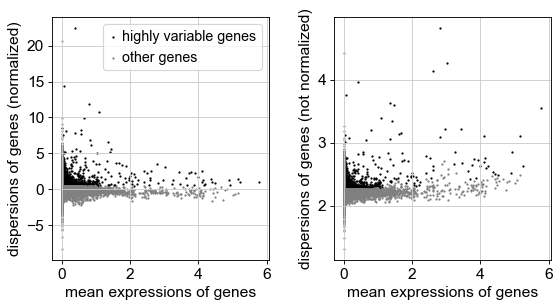

In [88]:
sc.pl.highly_variable_genes(adata_T)

In [89]:
adata_T.var['highly_variable'].value_counts()

False    10722
True      1841
Name: highly_variable, dtype: int64

In [90]:
adata_T.var.sort_values(by='dispersions_norm', ascending=False).head(10)

gene_ids  n_cells  highly_variable     means  dispersions  \
PTGDS     ENSG00000107317     1077             True  0.399067     3.954462   
PRSS1     ENSG00000204983       13            False  0.004034     4.421810   
PPBP      ENSG00000163736      299             True  0.062909     3.753645   
TYROBP    ENSG00000011600     3850             True  0.800496     3.194328   
FGFBP2    ENSG00000137441     5003             True  1.090819     3.391304   
S100B     ENSG00000160307     3324             True  0.650526     3.044628   
PVRL2     ENSG00000130202       14            False  0.002837     3.268674   
DNAJC28   ENSG00000177692       26            False  0.005363     3.179663   
C1orf112  ENSG00000000460       97             True  0.016355     3.120328   
FCGR3A    ENSG00000203747     3098             True  0.562738     2.858188   

          dispersions_norm  
PTGDS            22.506069  
PRSS1            20.660866  
PPBP             14.424458  
TYROBP           11.803353  
FGFBP2           10.699265  
S100B             9.972735  
PVRL2             9.897923  
DNAJC28           9.067123  
C1orf112          8.513316  
FCGR3A            8.214742

In [91]:
sc.tl.pca(adata_T, svd_solver='arpack', random_state=14, zero_center=True, use_highly_variable=True)

/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


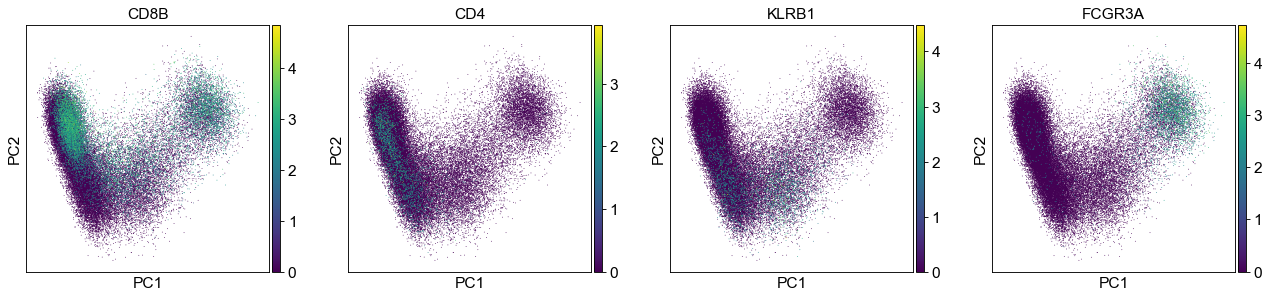

In [92]:
sc.pl.pca(adata_T, color=['CD8B', 'CD4', 'KLRB1', 'FCGR3A'], use_raw=False)

/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/dylankotliar/miniconda3/envs/py5coding/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


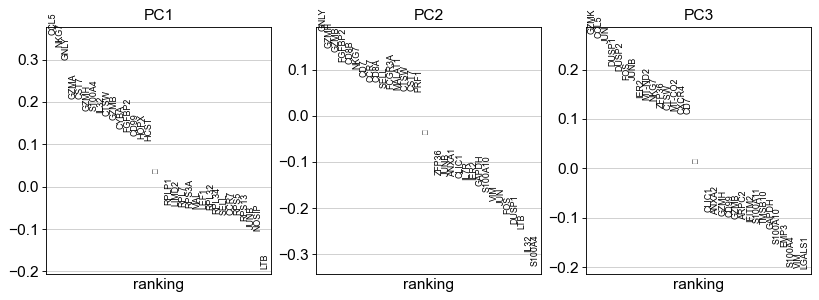

In [93]:
sc.pl.pca_loadings(adata_T)

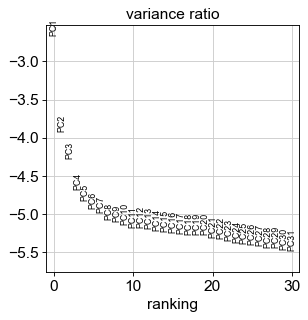

In [94]:
sc.pl.pca_variance_ratio(adata_T, log=True)

In [95]:
adata_T

AnnData object with n_obs × n_vars = 52899 × 12563
    obs: 'n_counts', 'doublet_scores', 'predicted_doublets', 'percent_mito', 'n_genes', 'log10_ncounts', 'leiden', 'ClusterFull_1', 'Cluster_1'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [96]:
sc.pp.neighbors(adata_T, n_neighbors=50, n_pcs=11, random_state=14)

In [97]:
sc.tl.umap(adata_T, min_dist=.5, spread=2.0, random_state=14)

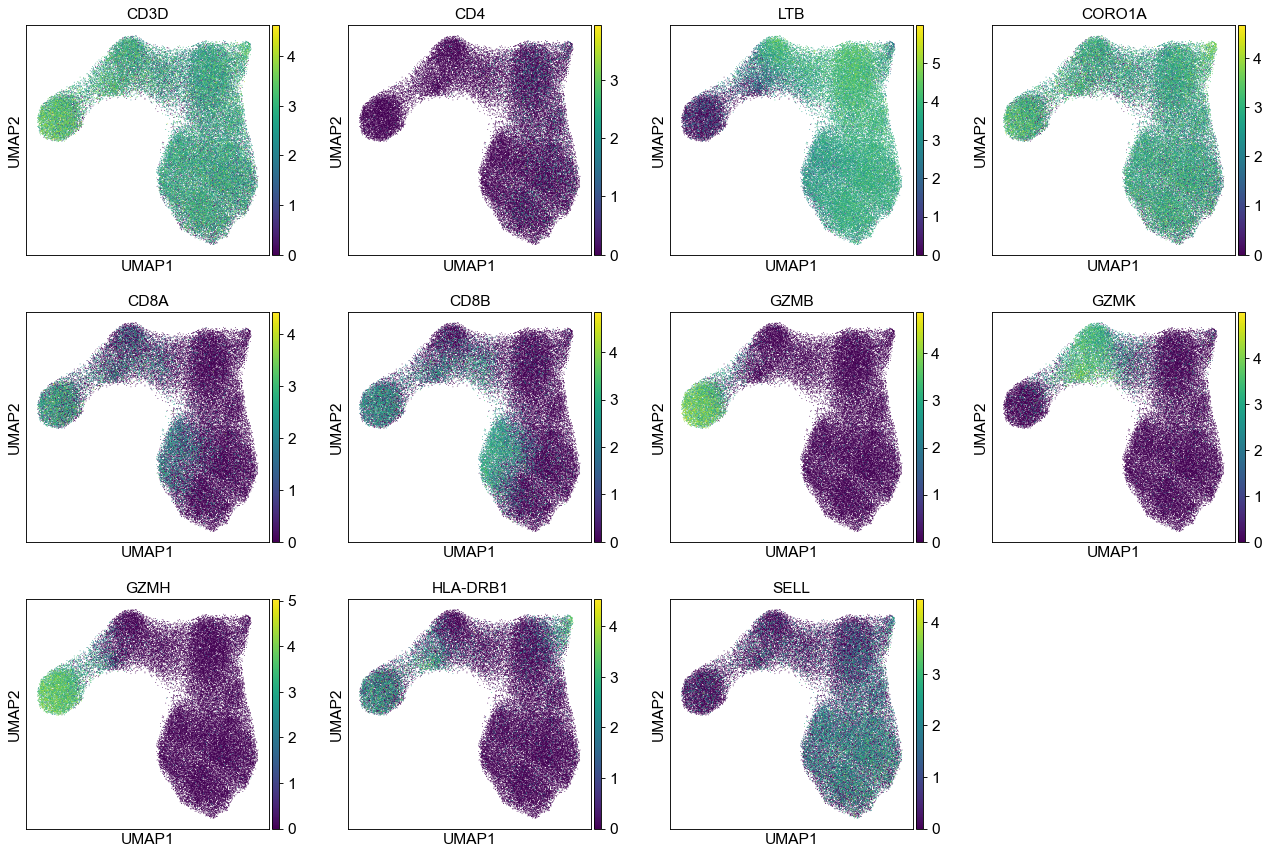

In [98]:
sc.pl.umap(adata_T, color=['CD3D', 'CD4', 'LTB', 'CORO1A', 'CD8A', 'CD8B', 'GZMB', 'GZMK','GZMH', 'HLA-DRB1', 'SELL'], use_raw=False)

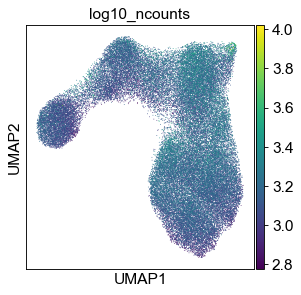

In [101]:
sc.pl.umap(adata_T, color=['log10_ncounts'])

In [102]:
sc.tl.leiden(adata_T, resolution=2.0, random_state=14)

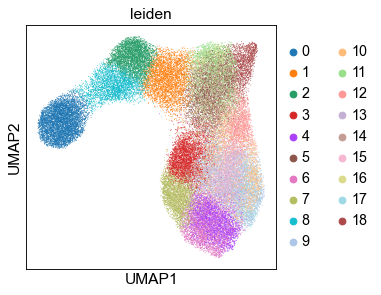

In [103]:
sc.pl.umap(adata_T, color=['leiden'])

In [104]:
adata_T.obs['leiden'].value_counts()

0     5606
1     3560
2     3525
3     3416
4     3269
5     3169
6     3132
7     3091
8     3018
9     2727
10    2668
11    2453
12    2303
13    2301
14    1935
15    1801
16    1794
17    1620
18    1511
Name: leiden, dtype: int64

In [105]:
sc.tl.rank_genes_groups(adata_T, use_raw=False, groupby='leiden')

In [106]:
pd.DataFrame(adata_T.uns['rank_genes_groups']['names']).head(50)

0         1        2       3       4         5       6       7  \
0       NKG7      CCL5     CCL5    CD8B   TXNIP    S100A4   RPL13    CD8B   
1       GNLY      IL32     GZMK    IER2   RPL32      IL32   RPL11   RPL13   
2       CCL5    S100A4     NKG7    RPS5   RPL13       LTB   RPL32   RPL32   
3       GZMH      GZMK    DUSP1   RPS3A   RPL11       VIM   RPS3A    RPS5   
4       GZMB      LYAR     GZMA    RPS6   RPS3A   S100A10    RPS6   RPS3A   
5        B2M       FOS     IL32   RPL13   RPS27     FXYD5   RPS13    RPS6   
6       CST7     DUSP1   S100A4   RPL32   RPS13     ANXA1  RPL18A   RPS13   
7      HLA-B       JUN      FOS    JUNB  RPL18A   S100A11   RPS27     CD7   
8      HLA-C      IL7R    DUSP2     CD7   RPL31      PLP2  RPL13A   RPS14   
9       GZMA       B2M     CST7    RPL7    RPS6      IL7R    RPL3    RPS2   
10    FGFBP2     HLA-B     CTSW   RPS12    RPL3  SH3BGRL3   RPL21   RPL31   
11      CTSW      KLF6      JUN    RPS2  RPL13A     COTL1    RPS2    RPL3   
12     HLA-A     DUSP2    HLA-B   RPL34  MALAT1      FTH1   RPS14   RPL11   
13      CYBA    PTGER2   MT-CO1  RPL10A   RPL21      CD52   RPL31   RPL21   
14    TMSB4X     ZFP36     LYAR   RPS13    RPS5     TIMP1   RPL19   RPS12   
15    S100A4     CXCR3     NCR3   RPS14   RPS14     TRADD    RPS5  RPL10A   
16  SH3BGRL3   ZFP36L2    HLA-C   S100B   RPS25    LGALS1   RPLP2   RPL19   
17      PRF1    MT-ND1    ZFP36  MT-CO2    RPL9     GSTK1   RPS12  RPL18A   
18      HOPX   S100A10   MT-CO3    RPS9    RPS9      AQP3  RPL10A   RPL34   
19    LGALS1       LTB   NFKBIA   RPL21   RPL10   TNFRSF4   RPL10    RPL9   
20    FCGR3A  SH3BGRL3    CEBPD    RPS8   RPLP2     CALM1    RPL7    RPL5   
21      CD99      JUNB      B2M   RPS25  RPL35A     ANXA2  MALAT1    RPL7   
22    MALAT1    MT-CO1      ID2    RPL5   RPL19     RPS18    RPL4   S100B   
23  HLA-DPB1     CXCR4    KLRG1  EEF1B2    RPS2      CAPG   RPS25    RPS9   
24      PFN1    MT-ND4     HCST   RPL31   RPS23    S100A6   RPS4X   RPS19   
25      CD8A     HLA-C     HOPX   RPS23   RPL34      KLF6   RPL34   RPLP2   
26      IL32      HOPX    KLRB1   RPL12    RPL7     RPLP1   RPS18   RPS25   
27      HCST    MT-ND2     CYBA   RPL18    RPS8     GAPDH    RPS9    RPL4   
28      CD63  PPP1R15A   MT-ND4   NOSIP    CCR7      EMP3   RPS23    RPS8   
29    TYROBP     TRADD   MT-ND1   RPL11   RPS12       B2M     LTB    CCR7   
30      CCL4     ANXA1  ZFP36L2    RPL9    RPL5      RPSA   RPL30   RPS23   
31  HLA-DRB1    NFKBIA    CXCR4    NPM1   RPL30     CLIC1    RPL9   RPL18   
32      SRGN      CD8B    HLA-A  RPL18A     LTB      RPL8  RPL35A   RPL10   
33  C12orf75     RPS19    CLIC1   RPL19  RPL10A     RPL11   RPL18    NPM1   
34  HLA-DRB5    MT-CO3     IL7R   RPS19    SELL    CORO1B   RPS15  EEF1B2   
35    ZNF683      NSG1   MT-ND2    RPL4   RPL18     CRIP1   RPS16   RPL12   
36    PRSS23     TIMP1   MT-CO2  MT-ND2    RPL4     RPLP0  RPS27A   RPS4X   
37     CLIC1      CTSW     MATK    LDHB   RPS15      RPS2    RPS8   RPS15   
38      LSP1  C9orf142   MT-CYB    CCR7    LDHB     RPL10    CCR7   RGS10   
39     SPON2    MT-CO2   FKBP11   LIMD2   RPS4X      FUT7    LDHB   RPS16   
40  HLA-DPA1   FAM173A  ALOX5AP   RPL15   RPS19    ARPC1B    RPL5  RPL13A   
41   PTPRCAP     HLA-A    H3F3B    RPL3  RPS27A    TAGLN2  RPS15A  RPL35A   
42    IFITM2       FTL    ARL4C   RGS10   RPL29    EEF1A1   RPL29   RPL15   
43  APOBEC3G     CLIC3   PMAIP1   RPLP2  RPS15A    TTC39C    NPM1    LDHB   
44     ASCL2     COTL1     GZMM   RPS15   RPS16      CTSH   RPS19   RPS27   
45      CD8B      CD99   CITED2  PABPC1   RPS18      LDHB  TMSB10    CARS   
46     ITGB2    MT-CYB     KLF6    CD8A   RPS20      CD99   RPS28   NUCB2   
47    S100A6    LGALS3   TYROBP   RPS16    NPM1      TPT1    RPL6    CD8A   
48     FCRL6  ARHGAP15     EIF1  TMEM66  TMEM66  ARHGAP15   RPL22    AIF1   
49     KLRD1      GZMA     LST1    CARS    BTG1     USP10  EEF1A1  TMSB10   

           8       9      10        11       12       13        14       15  \
0   

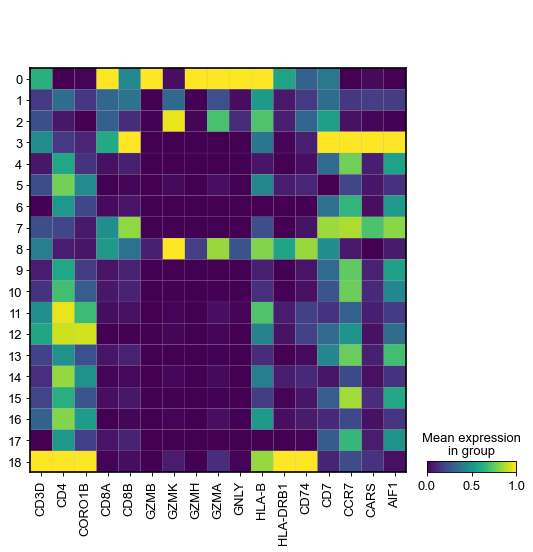

In [107]:
sc.pl.matrixplot(adata_T, var_names=['CD3D', 'CD4','CORO1B', 'CD8A', 'CD8B', 'GZMB', 'GZMK', 'GZMH', 'GZMA', 'GNLY', 'HLA-B', 'HLA-DRB1', 'CD74', 
                                     'CD7', 'CCR7', 'CARS', 'AIF1'],
                 groupby='leiden', standard_scale='var')

In [108]:
adata_T.write(results_T_file)


In [109]:
adata_T = sc.read(results_T_file)


In [112]:
from scipy.io import mmwrite

In [114]:
mmwrite('../data/Tcell50K_expression_log2TP10K_20210409.mtx', adata_T.X, precision=5)

In [119]:
adata_T.var[['gene_ids']].to_csv('../data/Tcell50K_expression_log2TP10K_20210409.genes.tsv', sep='\t', header=False)

In [124]:
with open('../data/Tcell50K_expression_log2TP10K_20210409.barcodes.tsv', 'w') as F:
    F.write('\n'.join(adata_T.obs.index))

In [ ]:
! gsutil -m cp ../data/Tcell50K* gs://sabeti-public/dkotliar/scnavigator/pbmc68k_Tcell/data/



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Copying file://../data/Tcell50K_expression_log2TP10K_20210409.barcodes.tsv [Content-Type=text/tab-separated-values]...
Copying file://../data/Tcell50K_expression_log2TP10K_20210409.genes.tsv [Content-Type=text/tab-separated-values]...
Copying file://../data/Tcell50K_expression_log2TP10K_20210409.mtx [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"pa